In [1]:
!git clone https://github.com/Duckkyy/3rd_year_experiment.git

Cloning into '3rd_year_experiment'...
remote: Enumerating objects: 37179, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 37179 (delta 6), reused 14 (delta 4), pack-reused 37163
Receiving objects: 100% (37179/37179), 1.21 GiB | 15.00 MiB/s, done.
Resolving deltas: 100% (14195/14195), done.
Updating files: 100% (38777/38777), done.


In [2]:
!find . -name ".DS_Store" -delete

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import cv2
from torch.utils.data import Dataset, DataLoader
import io 
import os 
from PIL import Image
from pathlib import Path

In [5]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time 
import copy

In [6]:
#Dataloader
data_path = '3rd_year_experiment/emotions/data/'
#Path for training and testing directory
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

In [7]:
def normalize_image(image_path):
    orig_img = Image.open(image_path)
    normalize_image = transforms.Resize(size=128)(orig_img) 
    
    image_name = os.path.splitext(image_path)[0]
    new_image_name = "{}_normalize.jpg".format(image_name)
    img_tag_ls = new_image_name.split('/')[-2:]
    img_tag = '/'.join(img_tag_ls)
    if not os.path.isfile(new_image_name):
        normalize_image.save(new_image_name)
    return img_tag

def rotation_image(image_path):
    orig_img = Image.open(image_path)
    rotation_image = transforms.RandomRotation(degrees=100)(orig_img)
    
    image_name = os.path.splitext(image_path)[0]
    new_image_name = "{}_rotation.jpg".format(image_name)
    img_tag_ls = new_image_name.split('/')[-2:]
    img_tag = '/'.join(img_tag_ls)
    if not os.path.isfile(new_image_name):
        rotation_image.save(new_image_name)
    return img_tag

def center_crop_image(image_path):
    orig_img = Image.open(image_path)
    crop_image = transforms.CenterCrop(size=128)(orig_img)
    
    image_name = os.path.splitext(image_path)[0]
    new_image_name = "{}_crop.jpg".format(image_name)
    img_tag_ls = new_image_name.split('/')[-2:]
    img_tag = '/'.join(img_tag_ls)
    if not os.path.isfile(new_image_name):
        crop_image.save(new_image_name)
    return img_tag

def gray_image(image_path):
    orig_img = Image.open(image_path)
    gray_image = transforms.Grayscale()(orig_img)
    
    image_name = os.path.splitext(image_path)[0]
    new_image_name = "{}_gray.jpg".format(image_name)
    img_tag_ls = new_image_name.split('/')[-2:]
    img_tag = '/'.join(img_tag_ls)
    if not os.path.isfile(new_image_name):
        gray_image.save(new_image_name)
    return img_tag

def blur_image(image_path):
    orig_img = Image.open(image_path)
    blur_image = transforms.GaussianBlur(kernel_size=(51,91), sigma=3)(orig_img)
    
    image_name = os.path.splitext(image_path)[0]
    new_image_name = "{}_blur.jpg".format(image_name)
    img_tag_ls = new_image_name.split('/')[-2:]
    img_tag = '/'.join(img_tag_ls)
    if not os.path.isfile(new_image_name):
        blur_image.save(new_image_name)
    return img_tag

def add_gaussian_noise(image, noise_factor=0.3):
    noisy = image + torch.randn_like(image) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

def add_random_boxes(org_img, block_num, size=32):
    h,w = size,size
    org_img = np.asarray(org_img)
    img = np.copy(org_img)

    img_size = img.shape[1]
    boxes = []
    for k in range(block_num):
        y, x = np.random.randint(0,img_size-w,(2,))
        # img.setflags(write=1)
        img.flags.writeable = True

        img[y:y+h, x:x+w] = 0
        boxes.append((x,y, h,w))
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

# orig_img = Image.open(Path(image_path))
def add_central_region(org_img, size=32):
    h,w = size,size
    org_img = np.asarray(org_img)
    img = np.copy(org_img)

    img_size = img.shape[1] 
    img[int(img_size/2-h) : int(img_size/2+h),int(img_size/2-w) : int(img_size/2+w)] = 0
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

def visualize_gaussian_image(image_path, transform_range=[0.3]):
    image_name = os.path.splitext(image_path)[0]
    img_tags = []
    orig_img = Image.open(Path(image_path))
    noise_imgs = [add_gaussian_noise(transforms.ToTensor()(orig_img),noise_factor) for noise_factor in transform_range]
    noise_imgs = [transforms.ToPILImage()(noise_img) for noise_img in noise_imgs]
    for idx, img in enumerate(noise_imgs):
        new_image_name = "{}_noise_{}.jpg".format(image_name, idx)
        img_tag = new_image_name.split('/')[-2:]
        img_tags.append('/'.join(img_tag))
        if not os.path.isfile(new_image_name):
            img.save(new_image_name)
        # img.show()
    return img_tags

def visualize_blocked_image(image_path, transform_range=[10]):
    image_name = os.path.splitext(image_path)[0]
    img_tags = []
    orig_img = Image.open(image_path)
    blocks_imgs = [[add_random_boxes(orig_img, block_num=i), i] for i in transform_range]
    for img in blocks_imgs:
        new_image_name = "{}_block_{}.jpg".format(image_name, img[1])
        img_tag = new_image_name.split('/')[-2:]
        # print(new_image_name)
        img_tags.append('/'.join(img_tag))
        if not os.path.isfile(new_image_name):
            img[0].save(new_image_name)
        # img[0].show()
    return img_tags

def visualize_central_image(image_path, transform_range=[32]):
    image_name = os.path.splitext(image_path)[0]
    img_tags = []
    orig_img = Image.open(image_path)
    central_imgs = [[add_central_region(orig_img,size=s), s] for s in transform_range]
    for img in central_imgs:
        new_image_name = "{}_central_{}.jpg".format(image_name, img[1])
        img_tag = new_image_name.split('/')[-2:]
        # print(img_tag)
        img_tags.append('/'.join(img_tag))
        if not os.path.isfile(new_image_name):
            img[0].save(new_image_name)
        # img[0].show()
    return img_tags

In [8]:
def augment_label_1_image(image_path):
    tag_list = []
    label_list = []
    gauss_transform_range = [0.3, 0.6, 0.9]
    central_transform_range = [5, 10, 15, 20]
    block_transform_range = [8, 16, 32, 64]

    tag_list.extend(visualize_central_image(image_path, transform_range=central_transform_range))
    tag_list.extend(visualize_blocked_image(image_path, transform_range=block_transform_range))
    tag_list.extend(visualize_gaussian_image(image_path, transform_range=gauss_transform_range))
    
    tag_list.append(blur_image(image_path))
    tag_list.append(rotation_image(image_path))
    tag_list.append(gray_image(image_path))
    tag_list.append(center_crop_image(image_path))
    tag_list.append(normalize_image(image_path))
    
    for i in range (1,17):
        label_list.append(1)
    return tag_list, label_list

def augment_double(image_path, img_idx, label:int):
    tag_list = []
    label_list = []
    idx = img_idx % 8
    if idx == 0:
        tag_list.extend(visualize_central_image(image_path))
    elif idx == 1:
        tag_list.extend(visualize_gaussian_image(image_path))
    elif idx == 2:
        tag_list.extend(visualize_blocked_image(image_path))
    elif idx == 3:
        tag_list.append(blur_image(image_path))
    elif idx == 4:
        tag_list.append(rotation_image(image_path))
    elif idx == 5:
        tag_list.append(gray_image(image_path))
    elif idx == 6:
        tag_list.append(center_crop_image(image_path))
    elif idx == 7:
        tag_list.append(normalize_image(image_path))
    label_list.append(label)
    return tag_list, label_list

def augment_triple(image_path, img_idx):
    tag_list = []
    label_list = []
    idx = img_idx % 4
    if idx == 0:
        tag_list.extend(visualize_central_image(image_path))
        tag_list.append(rotation_image(image_path))
    elif idx == 1:
        tag_list.extend(visualize_gaussian_image(image_path))
        tag_list.append(gray_image(image_path))
    elif idx == 2:
        tag_list.extend(visualize_blocked_image(image_path))
        tag_list.append(center_crop_image(image_path))
    elif idx == 3:
        tag_list.append(blur_image(image_path))
        tag_list.append(normalize_image(image_path))
        
    label_list.append(2)
    label_list.append(2)
    return tag_list, label_list

def augment_six_times(image_path):
    tag_list = []
    label_list = []

    tag_list.extend(visualize_central_image(image_path))
    tag_list.extend(visualize_gaussian_image(image_path))
    
    tag_list.append(blur_image(image_path))
    tag_list.append(rotation_image(image_path))
    tag_list.append(gray_image(image_path))
    # tag_list.append(center_crop_image(image_path))
    for i in range(5):
        label_list.append(6)
    return tag_list, label_list

In [7]:
import glob
for i in range (1,8):
    a = glob.glob(f"3rd_year_experiment/emotions/data/train/{str(i)}/*/*.jpg")
    print(len(a))

25
197
264
518
241
82
260


In [8]:
train_data_path = '3rd_year_experiment/emotions/Labels/ground_truth_train.csv'
train_data = pd.read_csv(train_data_path, on_bad_lines='skip')
len(train_data)

1587

In [9]:
train_data_path = '3rd_year_experiment/emotions/Labels/ground_truth_train.csv'
train_data = pd.read_csv(train_data_path, on_bad_lines='skip')
new_img_list = []
new_label_list = []
label_2 = 0
label_3 = 0
label_5 = 0
label_7 = 0
for i in range(len(train_data)):
    label = train_data['label'][i]
    if i % 5 == 0:
        print(label, i)
    tag_list = []
    label_list = []
    image_path = os.path.join(train_dir, str(label), train_data['image'][i])
    if label == 1:
        tag_list, label_list = augment_label_1_image(image_path)
    
    elif label == 6:
        tag_list, label_list = augment_six_times(image_path)
    
    elif label == 2:
        img_idx = label_2
        label_2 += 1
        tag_list, label_list = augment_triple(image_path, img_idx)
    
    elif label != 4:
        img_idx = 0       
        if label == 3:
            img_idx = label_3
            label_3 += 1
#         elif label == 2:
#             img_idx = label_2
#             label_2 += 1
        elif label == 5:
            img_idx = label_5
            label_5 += 1
        else:
            img_idx = label_7
            label_7 += 1
        tag_list, label_list = augment_double(image_path, img_idx, label)
        
    else:
        continue
        
    new_img_list.extend(tag_list)
    new_label_list.extend(label_list)

new_data = {
    'image': new_img_list,
    'label': new_label_list
}
df1 = pd.DataFrame(new_data)
df1.to_csv(train_data_path, mode='a', index=False, header=False)
print("Data appended successfully: ", df1)

2 0


NameError: name 'augment_triple' is not defined

In [10]:
train_data_path = '3rd_year_experiment/emotions/Labels/ground_truth_train.csv'
a = pd.read_csv(train_data_path, on_bad_lines='skip')

drop_label = []
for idx in range(len(a['image'])):
    if a['image'][idx][-3:] != 'jpg':
        drop_label.append(idx)
# print(len(drop_label))
# a = a.drop(labels=drop_label, axis=0)


In [11]:
# train_data_path = '3rd_year_experiment/emotions/Labels/ground_truth_train.csv'
# a = pd.read_csv(train_data_path, on_bad_lines='skip')

In [12]:
labelArr = a['label'].unique()
label2id = {}
id2label = {}
index = 0
for class_name in labelArr:
    label2id[class_name] = str(index)
    id2label[str(index)] = class_name
    index += 1
print(label2id)
print(id2label)

{2: '0', 4: '1', 3: '2', 5: '3', 7: '4', 6: '5', 1: '6'}
{'0': 2, '1': 4, '2': 3, '3': 5, '4': 7, '5': 6, '6': 1}


In [13]:
model_name = 'resnet'
num_classes = 7
batch_size = 64
num_epochs = 50
feature_extract = False

In [14]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 1]), self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(label2id[labelKey]))
            
        else:
            label = torch.tensor(1)
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [15]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(a, test_size=0.05)
print(len(train))
print(len(valid))

1507
80


In [16]:
train['label'].value_counts()

4    496
3    249
7    248
5    228
2    185
6     78
1     23
Name: label, dtype: int64

In [17]:
input_size = 224
transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
train_dataset = EmotionDataset(train, root_dir=train_dir, is_train=True, transform=transform_train)
valid_dataset = EmotionDataset(valid, root_dir=train_dir, is_train=True, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
dataloaders_dict ={}
dataloaders_dict['train']= train_loader
dataloaders_dict['val'] = val_loader

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  import sys


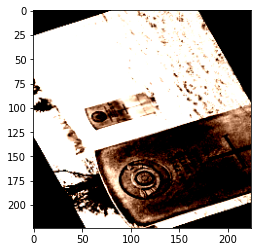

Label: 2


In [20]:
# for i, (images,labels) in enumerate(train_loader):
#     print(images)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
img = (img.T).detach().numpy()
label = train_labels[0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Label: {label}")

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [23]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        #models.resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_classes)
                                    )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_classes)
                                    )
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

model_name = 'densenet'
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [24]:
# Send the model to GPU
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print(f'using {device} device')
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            # print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=2e-3, momentum=0.9,weight_decay=1e-6, nesterov=True)
# optimizer_ft = optim.Adam(params_to_update, lr=1e-3)

using cpu device
Params to learn:


In [27]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 1.6689 Acc: 0.3602
val Loss: 1.4059 Acc: 0.5281

Epoch 1/49
----------
train Loss: 1.2310 Acc: 0.5501
val Loss: 1.2366 Acc: 0.5843

Epoch 2/49
----------
train Loss: 0.9814 Acc: 0.6602
val Loss: 1.1531 Acc: 0.5674

Epoch 3/49
----------
train Loss: 0.8074 Acc: 0.7189
val Loss: 1.0632 Acc: 0.6292

Epoch 4/49
----------
train Loss: 0.6491 Acc: 0.7823
val Loss: 1.0376 Acc: 0.6348

Epoch 5/49
----------
train Loss: 0.5278 Acc: 0.8306
val Loss: 0.8997 Acc: 0.6517

Epoch 6/49
----------
train Loss: 0.3992 Acc: 0.8789
val Loss: 0.9778 Acc: 0.6629

Epoch 7/49
----------
train Loss: 0.3330 Acc: 0.9011
val Loss: 0.9419 Acc: 0.6629

Epoch 8/49
----------
train Loss: 0.2646 Acc: 0.9224
val Loss: 0.8198 Acc: 0.6966

Epoch 9/49
----------
train Loss: 0.1991 Acc: 0.9434
val Loss: 0.8677 Acc: 0.7022

Epoch 10/49
----------
train Loss: 0.1516 Acc: 0.9653
val Loss: 0.8004 Acc: 0.7079

Epoch 11/49
----------
train Loss: 0.1330 Acc: 0.9653
val Loss: 0.8127 Acc: 0.7416

Ep

In [25]:
os.path.isfile('3rd_year_experiment/emotions/emotion_densenet_augmented_1-4.pt')

True

In [26]:
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load('3rd_year_experiment/emotions/weight/emotion_densenet_augmented_1-2.pt', map_location=torch.device('cpu'))
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch, loss)

50 [tensor(0.5281, dtype=torch.float64), tensor(0.5843, dtype=torch.float64), tensor(0.5674, dtype=torch.float64), tensor(0.6292, dtype=torch.float64), tensor(0.6348, dtype=torch.float64), tensor(0.6517, dtype=torch.float64), tensor(0.6629, dtype=torch.float64), tensor(0.6629, dtype=torch.float64), tensor(0.6966, dtype=torch.float64), tensor(0.7022, dtype=torch.float64), tensor(0.7079, dtype=torch.float64), tensor(0.7416, dtype=torch.float64), tensor(0.7472, dtype=torch.float64), tensor(0.7416, dtype=torch.float64), tensor(0.7753, dtype=torch.float64), tensor(0.7303, dtype=torch.float64), tensor(0.7360, dtype=torch.float64), tensor(0.7584, dtype=torch.float64), tensor(0.7697, dtype=torch.float64), tensor(0.7528, dtype=torch.float64), tensor(0.7865, dtype=torch.float64), tensor(0.7753, dtype=torch.float64), tensor(0.7640, dtype=torch.float64), tensor(0.7584, dtype=torch.float64), tensor(0.7921, dtype=torch.float64), tensor(0.7809, dtype=torch.float64), tensor(0.7753, dtype=torch.float64

In [27]:
class TestDataset(Dataset):
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,self.dataframe.iloc[idx, 0]

In [28]:
label_path = "3rd_year_experiment/emotions/Labels"
test_label_path = os.path.join(label_path, "ground_truth_test.csv")
test_dataframe = pd.read_csv(test_label_path)
test_dataframe.head()

,image
0,anger/230.jpg
1,disgust/245.jpg
2,disgust/249.jpg
3,joy/253.jpg
4,disgust/255.jpg


In [29]:
data_path = '3rd_year_experiment/emotions/data/'
test_dir = os.path.join(data_path, "test")
print(os.listdir(test_dir))

['joy', 'disgust', 'anger', 'sadness', 'surprise', 'fear']


In [30]:
test_dataset = TestDataset(test_dataframe, root_dir=test_dir, transform=transform_valid)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2)

In [31]:
#model_ft.cuda()
model_ft.eval()
filenames=[]
finalpredictions=[]
for inputs, files in test_loader:
                # print(inputs)
                # print(files)
                inputs = inputs.to(device)
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                finalpred=[]
                for file in files:
                    filenames.append(file)
                for pred in preds:
                    finalpredictions.append(id2label[str(pred.item())])
                #print(finalpred)

In [32]:
df_preds = pd.DataFrame({'image': filenames, "label": finalpredictions})
df_preds.head()
df_preds['label'].value_counts()

4    163
3     62
7     60
5     52
2     37
6     14
1      5
Name: label, dtype: int64

In [33]:
df_preds.to_csv("sample_submission.csv", index=False)

In [ ]:
print(len(submission_df))

In [28]:
# torch.save(model_ft,"EmotionSquuezenet.pt")

torch.save({'epoch': num_epochs,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'loss': hist}, 
            "emotion_densenet_augmented_1.pt")